<a href="https://colab.research.google.com/github/DianaShramchenko/works/blob/main/8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Генеративно-состязательная сеть (GAN)**

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример №1](https://www.kaggle.com/datasets/andrewmvd/medical-mnist), [Пример №2](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data#example), [Пример №3](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))





In [ ]:
# Ваш
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
from urllib.request import urlopen
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from imutils import paths
import os
import tensorflow as tf
import random

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/content/dataset/")))
print(imagePaths[100].split(os.path.sep)[-2])
random.shuffle(imagePaths)

3


In [ ]:
# Путь к данным
data_dir = "/content/drive/MyDrive/content/dataset/"

In [ ]:
def load_images(imagePaths, compression_size = 32):
  data = []
  labels = []

  for imagePath in imagePaths:
    # Загрузка изображения
    image = cv2.imread(imagePath)

    # Изменение разрешения изображения
    image = cv2.resize(image, (compression_size, compression_size))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Инвертирую изображение
    #image = 255 - image
    # Добавление изображения в список
    data.append(image)

    # Извлечение метки класса из пути к изображению
    label = imagePath.split(os.path.sep)[-2]

    # Добавление метки в список
    labels.append(label)

  data = np.array(data)

  return data, labels

In [ ]:
  #Функция np.save сохраняет массив в формате NumPy,
  #который позволяет быстро загружать и сохранять большие массивы данных в бинарном формате.
X_train, _ = load_images(imagePaths, 28)
np.save('/content/drive/MyDrive/content/dataset/notes.npy', X_train)

In [ ]:
#Конструктор Генератора
def build_generator():
    # Вектор случайного шума, используемый в качестве входного слоя для Генератора:
    noise_shape = (100,) # 1D массив размером 100 (латентный вектор / шум)

    model = Sequential()

    #Alpha - α - это гиперпараметр, который управляет базовым значением, на который функция
    # функция домножает отрицательные входы сети.
    #Momentum - «задержка» в обучении среднего значения и дисперсии, поэтому шум из-за мини-пакета можно игнорировать
    # Ссылка: https://medium.com/@ilango100/batchnorm-fine-tune-your-booster-bef9f9493e22

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))#model.add(ELU(alpha=0.2))#
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)


In [ ]:
#Конструктор Дискриминатора
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(ELU(alpha=0.2))#model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)  # предположение дискриминатора о том, является ли входное изображение реальным или нет.

    return Model(img, validity)

In [ ]:
#Функции для сохранения и загрузки параметров моделей (GAN, Generator, Discriminator) с возможностью дообучения
from tensorflow.keras.models import load_model, save_model

def save(gan, generator, discriminator):
    root_path = ''
    discriminator.trainable = False
    save_model(gan, root_path+'gan')
    discriminator.trainable = True
    save_model(generator, root_path + 'generator')
    save_model(discriminator, root_path + 'discriminator')

In [ ]:
def load():
    root_path = ''
    discriminator = load_model(root_path + 'discriminator')
    generator = load_model(root_path + 'generator')
    gan = load_model(root_path + 'gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [ ]:
#Функция обучения
def train(epochs, batch_size=128, save_interval=50):
    #compression_size = 28
    # Загружаем набор данных
    #X_train, _ = load_images(imagePaths, compression_size)
    X_train = np.load("/content/drive/MyDrive/content/dataset/notes.npy")
    # Преобразование в тип float и нормализация от -1 до 1 (можно также от 0 до 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Добавляем размерность каналов. В качестве входных данных для наших gen и discr. имеет форму 28x28x1.
    #X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)


    #Обучаем Дискриминатор,
    # выбираем случайную партию изображений из нашего истинного набора данных,
    # генерируем набор изображений с помощью Генератора, затем подаём оба набора изображений в наш Дискриминатор,
    # и, наконец, вычисляем параметры функции потерь для реальных и сгенерированных
    #  (поддельных) изображений, а также комбинированные потери.

    for epoch in range(epochs):

        # ---------------------
        #  Обучение Дискриминатора
        # ---------------------

        # Выберите случайную половину партии реальных изображений
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]


        noise = np.random.normal(0, 1, (half_batch, 100))

        # Сгенерируем половину партии поддельных изображений
        gen_imgs = generator.predict(noise)

        # Обучение дискриминатора на реальных и поддельных изображениях отдельно.
        # Исследования показали, что раздельное обучение более эффективно.
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Процесс обучения происходит с помощью метода train_on_batch()
        # Ссылка:https://keras.io/api/models/model_training_apis/

        # Вычисление средней потери от реальных и поддельных изображений.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #И в том же цикле мы обучаем наш Генератор, задавая входной шум
        # и в конечном итоге обучая Генератор тому, чтобы Дискриминатор
        # помечал его образцы как достоверные задавая градиентные потери.

        # ---------------------
        #  Обучение Генератора
        # ---------------------

        #Создаём векторы случайного шума в качестве входных данных для генератора.
        # На каждую партию необходимо создать свой вектор.
        # Шум основано на нормальном распределении (от 0 до 1).
        # Выходные данные будут иметь размер (размер партии, 100)

        noise = np.random.normal(0, 1, (batch_size, 100))

        # Генератору необходимо добиться того, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (1)
        # Здесь генератор пытается "обмануть" дискриминатор, чтобы тот "поверил", в то
        # что сгенерированный образ является истинным (отсюда значение 1 для y)
        valid_y = np.array([1] * batch_size) #Создает массив всех единиц размера size=batch size

        # Генератор является частью комбинированной системы, где он напрямую связан с дискриминатором.
        # Обучим генератор, используя шум в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он состязательный,
        # и если генератор отлично справился со своей р работой по следованию дискриминатору, то на выходе будет 1 (истина).

        g_loss = combined.train_on_batch(noise, valid_y)


#Дополнительно, чтобы мы могли отслеживать процесс обучения, мы выводим на печать
# прогресс и сохраняем вывод образцов изображений в зависимости от заданного интервала эпох,
# а также по желанию, можем сохранять модель.

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                save(combined, generator, discriminator)


In [ ]:
#Функция save_imgs() сохраняет сгенерированные изображения для просмотра:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
# Определим наш оптимизатор для удобства использования в дальнейшем.
optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)  #Скорость обучения и экспоненциальная скорость затухания для оценок первого момента.

In [ ]:
from tensorflow.keras.layers import ELU

In [ ]:
#Построим модель Дискриминатора, вызывая соответствующую функцию, написанную выше,
#и скомпилируем её.Генератор будет обучен как часть комбинированной модели.
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               401920    
                                                                 
 elu (ELU)                   (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [ ]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                     

In [ ]:
#Создаём Генератор и определяем входной шум
z = Input(shape=(100,))
img = generator(z)

In [ ]:
#Во время обучения генератора мы не хотим, чтобы веса дискриминатора корректировались. (Это не влияет на обучение дескриминатора)

discriminator.trainable = False

In [ ]:
valid = discriminator(img)  #Проверка достоверности сгенерированного изображения

In [ ]:
#алее мы объединяем модели, а также задаём функцию потерь и оптимизатор.
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
#Обучаем модель и сохраняем модель генератора её после обучения:
train(epochs=10000, batch_size=12, save_interval=2000)

generator.save('generator_model_final.h5')

Выходные данные были обрезаны до нескольких последних строк (5000).
7500 [D loss: 0.016628, acc.: 100.00%] [G loss: 4.100230]
1/1 [==============================] - 0s 19ms/step
7501 [D loss: 0.520638, acc.: 83.33%] [G loss: 2.959175]
1/1 [==============================] - 0s 19ms/step
7502 [D loss: 0.048533, acc.: 100.00%] [G loss: 2.920579]
1/1 [==============================] - 0s 19ms/step
7503 [D loss: 0.069807, acc.: 100.00%] [G loss: 3.650939]
1/1 [==============================] - 0s 19ms/step
7504 [D loss: 0.014965, acc.: 100.00%] [G loss: 4.027702]
1/1 [==============================] - 0s 25ms/step
7505 [D loss: 0.029883, acc.: 100.00%] [G loss: 3.808542]
1/1 [==============================] - 0s 19ms/step
7506 [D loss: 0.012861, acc.: 100.00%] [G loss: 4.089255]
1/1 [==============================] - 0s 20ms/step
7507 [D loss: 0.012762, acc.: 100.00%] [G loss: 4.122482]
1/1 [==============================] - 0s 19ms/step
7508 [D loss: 0.010509, acc.: 100.00%] [G loss: 4.296

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Демонстрация сгенерированных изображений:

1/1 [==============================] - 0s 124ms/step


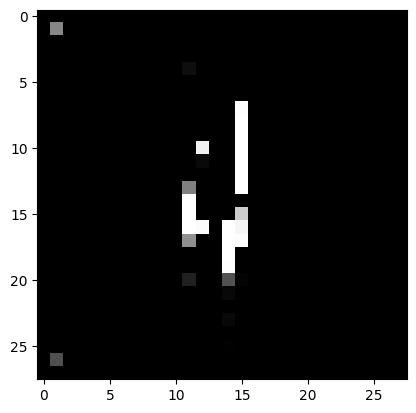

In [ ]:
# Ваш кодfrom keras.models import load_model
from numpy import asarray
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randn

model = load_model('generator_model_final.h5')
#model = generator

# Чтобы создать одинаковое изображение, каждый раз подавайте один и тот же вектор.

#Для создания случайных изображений каждый раз...
vector = randn(100) #Вектор случайных чисел (создает столбец, необходимо изменить форму)
vector = vector.reshape(1, 100)

# сгенеруем изображение
X = model.predict(vector)

# Выведем результат
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

In [ ]:

def generate_latent_points(latent_dim, n_samples):
  # генерируем случайные вектора по количеству n_samples
	x_input = randn(latent_dim * n_samples)
	# переформировать в пакет входных данных для сети
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

1/1 [==============================] - 0s 171ms/step


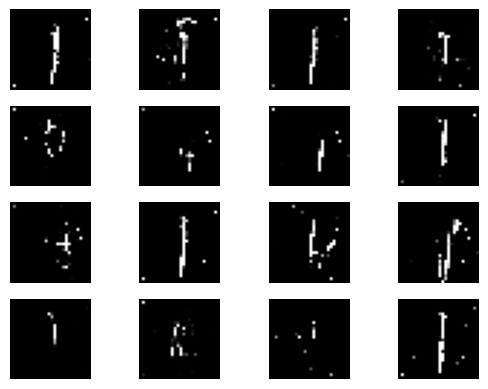

In [ ]:
model = load_model('generator_model_final.h5')
#model = generator


# Сгенерируем 16 векторов случайного шума
latent_points = generate_latent_points(100, 16)

# Генерируем изображения га основе сгенерированных векторов
X = model.predict(latent_points)

# Выводим результаты
save_plot(X, 4)  # Таблица 4x4 (Можно изменить на 5 для генерации и вывода 25 изображений)

# **Задание №2.** Обучите генератор воспризводить примитивные изображения по заданному условию (Conditional Generative Adversarial Nets (CGAN)).

(На вход генератора подается вектор случайного шума и метка класса - на выходе должно получиться изображение, соответствующее данному классу)

Датасет выберите по желанию. ([Пример №1](https://www.kaggle.com/datasets/andrewmvd/medical-mnist), [Пример №2](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data#example), [Пример №3](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [ ]:
# Ваш код
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

In [ ]:
img_rows = 32
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)

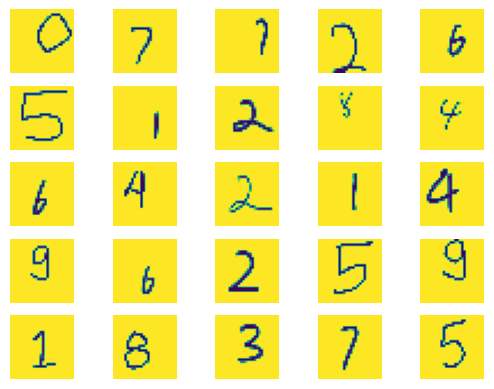

In [ ]:

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X_train[i])
plt.show()

In [ ]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):

    # Входная метка класса
	in_label = Input(shape=(1,))
    #Каждая метка (всего 10 классов для cifar) будет представлена вектором размера 50.
    #Этот вектор размера 50 будет изучаться дискриминатором.
	li = Embedding(n_classes, 50)(in_label) #Shape = 1,50 (https://keras.io/api/layers/core_layers/embedding/)
	# масштабирование до размеров изображения
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# изменим форму с добавлением канала
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# Входное изображение
	in_image = Input(shape=in_shape) #32x32x3
  # Добавляем метку кDense(n_nodes)ласса в качестве последнего канала
	merge = Concatenate()([in_image, li]) #32x32x4 (4 канала, 3 для изображения и четвертый для метки класса)

	# понижение дискретизации: Эта часть аналогична GAN из прошлой работы до выходного слоя.
  #Мы объединим входную метку с входным изображением и подадим их на вход модели.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# понижение дискретизации
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# выровненная карта признаков
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# Комбинируем входную метку с входным изображением и подаем в качестве входных данных в модель.
	model = Model([in_image, in_label], out_layer)
	# Компилируем модель
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_10[0][0]']            
                                                                                                  
 dense_24 (Dense)            (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_11 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                            

In [ ]:
#Конструктор Генератора
def define_generator(latent_dim, n_classes=10):

	# Входная метка класса
	in_label = Input(shape=(1,))  #Вход размерности 1
	#Каждая метка (всего 10 классов для cifar), будет представлена вектором размером 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# линейное умножение
	n_nodes = 8 * 8  # Чтобы сопоставить размеры для конкатенации позже
	li = Dense(n_nodes)(li) #1,64
	# изменим форму с добавлением канала
	li = Reshape((8, 8, 1))(li)


	# входной слой генератора изображений
	in_lat = Input(shape=(latent_dim,))  #Вход размером 100

	# Пусть базовое изображение будет иметь размерность 8x8
    # Для этого необходимо преобразовать входной латентный вектор в изображение 8x8.
    #Таким образом, значение n_nodes для полносвязного слоя может быть 8192 (128*8*8)
    # это позволит нам преобразовать его в "изображение" с размерностью 8x8x128
    # которое мы постепенно будем "увеличивать" до размерности 32x32х3 для вывода.
    #При определении входов модели мы объединим входную метку и латентный вход.

	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# объединяем входные данные изображения и соответствующей ему метки класса
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Дополнительный канал соответствующий метке класса)
	# увеличиваем дискретизацию до 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# увеличиваем дискретизацию до to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# Выходной слой
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
  # определяем модель
	model = Model([in_lat, in_label], out_layer)
	return model   #Модель не компилируется, поскольку она не обучается напрямую, как дискриминатор.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_27 (Dense)            (None, 8192)                 827392    ['input_13[0][0]']            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_12[0][0]']            
                                                                                           

In [ ]:
#Конструктор комбинированой модели GAN
def define_gan(g_model, d_model):
  d_model.trainable = False  # Дискриминатор обучается отдельно, поэтому делаем его необучаемым.

    ## соединяем генератор и дискриминатор
	# сначала получаем входные данные - вектор шума и метки из модели генератора
  gen_noise, gen_label = g_model.input
	# получение выходного изображения из модели генератора
  gen_output = g_model.output  #32x32x3

  # выходное изображение генератора и соответствующая входная метка являются входами для дискриминатора
  gan_output = d_model([gen_output, gen_label])
	# определим gan-модель как модель принимающую на вход вектор шума и метку класса (для генератора), и выдающую значение классификатора дискриминатора
  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
# загружаем изображения из датасета cifar10
def load_real_samples(image_paths, img_shape=(32, 32)):
    data = []
    for image_path in image_paths:
        # Загружаем изображение и изменяем его размер
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        data.append(image)
    X = np.array(data, dtype='float32')
    # Нормализуем значения из начального диапазона [0,255] в диапазон [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [ ]:
#Генератор набора реальных изображений
def generate_real_samples(dataset, n_samples):
	# разделяем изображения и метки
  images, labels = dataset
	# выбираем случайные экземпляры
  ix = randint(0, images.shape[0], n_samples)
	# выбераем изображения и метки
  X, labels = images[ix], labels[ix]
  # генерируем метки классов и присваиваем их переменной y
  #  (не путайте с вышеуказанными метками, которые соответствуют меткам cifar)
  y = ones((n_samples, 1))  #Label=1 идентифицирует о том, что изображение реальное
  return [X, labels], y

In [ ]:
# Для генерации случайного шума используется функция, описанная выше
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))  #Label=0 указывает на то, что они поддельные
	return [images, labels_input], y

In [ ]:
#Функция для генерации вектора случайного шума по заданному количеству экземпляров
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
# Функция для обучения моделейr
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #модель дискриминатора обновляется для половины партии реальных образцов
                            #и половины партии поддельных образцов, объединенных в одну партию.
	for i in range(n_epochs):
		for j in range(bat_per_epo):

      # Обучаем дискриминатор на реальных и поддельных изображениях, отдельно (по половине партии каждого).
      # Исследования показали, что раздельное обучение более эффективно.

			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      # обновление весов модели дискриминатора
      # train_on_batch позволяет обновлять веса на основе коллекции предоставляемых образцов

			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# генерируем поддельные примеры
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# обновляем веса модели дискриминатора
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)


			# генерация вектором случайного шума для нужного числа экземпляров в качестве входных данных для генератора
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

        # Генератор хочет, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (единицы)
        # Здесь генератор пытается обмануть дискриминатор, чтобы тот поверил.
        # что сгенерированное изображение истинно (отсюда значение 1 для y)
			  # поэтому для поддельных образцов мы создаём инвертированные метки
			y_gan = ones((n_batch, 1))

        # Генератор является частью комбинированной модели, где он напрямую связан с дискриминатором.
        # Обучите генератор с latent_dim в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он является состязательным, и если генератор отлично справился со своей задачей.
        # работу по следованию дискриминатору, то на выходе будет 1 (true)
			  # обновить генератор через ошибку дискриминатора

			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Выводим потери по этой партии
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

In [ ]:
X.shape

(16, 28, 28, 1)

In [ ]:
# Определение параметров и создание моделей
img_shape = (32, 32, 3)  # Размер изображений и количество каналов (RGB)
image_paths = sorted(list(paths.list_images("/content/drive/MyDrive/content/dataset/")))


In [ ]:
import numpy as np

In [ ]:
# Размерность вектора случайного шума
latent_dim = 100
# создание модели дискриминатора
d_model = define_discriminator()
# создание модели генератора
g_model = define_generator(latent_dim)
# создание комбинированной модели GAN
gan_model = define_gan(g_model, d_model)
# загрузка датасета
dataset = load_real_samples(image_paths, img_shape[:2])
# обучение модели
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

# сохранение обученной модели генератора (без возможности дообучения)
g_model.save('cifar_generator_25epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Демонстрация сгенерированных изображений:

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [ ]:
model = load_model('/content/cifar_generator_25epochs.h5')

4/4 [==============================] - 0s 9ms/step


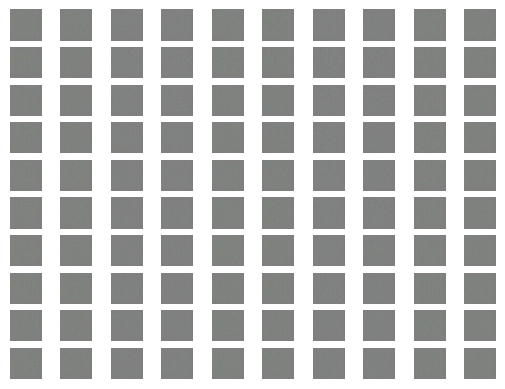

In [ ]:
# генерируем набор случайных векторов и меток классов
latent_points, labels = generate_latent_points(100, 100)

# задаём метки классов - генерируем 10 наборов меток,
# каждая из которых имеет значение от 0 до 9
labels = asarray([x for _ in range(10) for x in range(10)])

# Генерируем изображения
X  = model.predict([latent_points, labels])

# Преобразуем значения каждого пикселя в диапазон [0, 255] из диапазона [-1,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# Выводим сгенерированные изображения (По 10 изображений для каждого класса)
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.savefig('cifar.png', dpi = 300)
	plt.show()

show_plot(X, 10)

In [ ]:
print(f'Latent points shape: {latent_points.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Generated images shape: {X.shape}')
print(f'Pixel values range: {X.min()} to {X.max()}')

Latent points shape: (100, 100)
Labels shape: (100,)
Generated images shape: (100, 32, 32, 3)
Pixel values range: 117 to 141


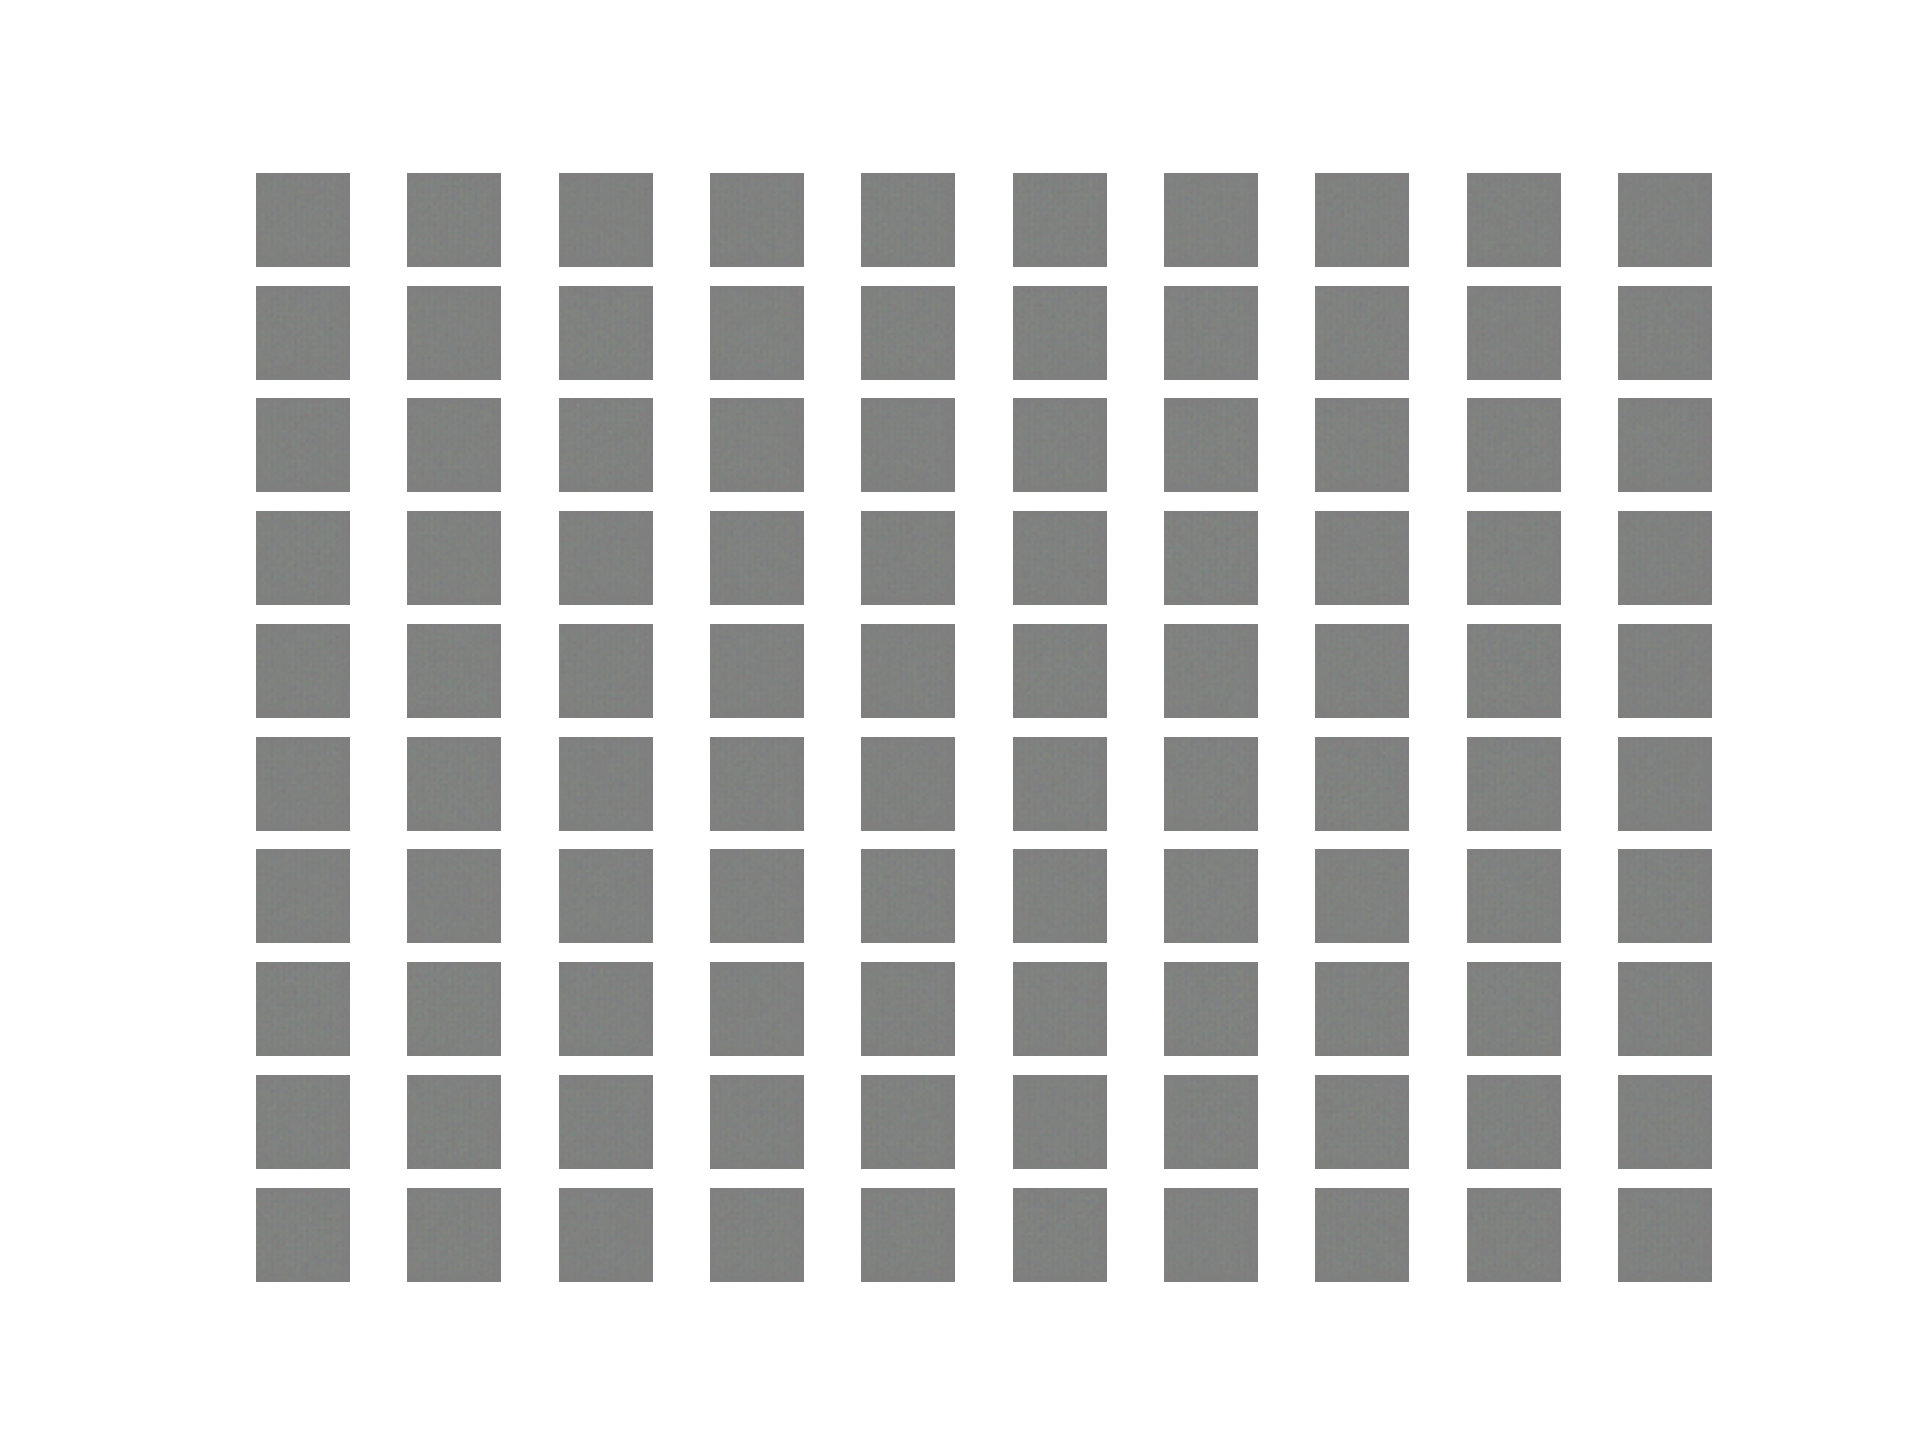

In [ ]:
from IPython.display import Image
Image('/content/cifar.png')

# **Задание №3.** Обучите генератор воспризводить **спутниковый снимок** по **загруженной маске** (pix2pix). Используйте для этого разделенный на патчи  [датасет](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery)

In [ ]:
# Ваш код from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
def define_discriminator(image_shape):

	# инициализация веса
	init = RandomNormal(stddev=0.02) # Как описано в оригинальной статье

	# Входной слой для исходного изображения
	in_src_image = Input(shape=image_shape)  # Изображение, которое мы хотим преобразовать в другое изображение
       # Входной слой для целевого изображения
	in_target_image = Input(shape=image_shape)  # Изображение, которое мы хотим получить после обучения.

       # конкатенируем изображения по каналам
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2. Этот блок кода добавлен самостоятельно, его нет в оригинальной статье. Закомментируйте его, если хотите.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# последний выходной слой: 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# формирование патча
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# определяем модель
	model = Model([in_src_image, in_target_image], patch_out)

   #Модель обучается с размером партии в одно изображение, оптимизатором Adam с небольшой скоростью обучения и значением beta = 0.5.
    # Устанавливаем весовой коэффициент для дискриминатора в 50% (0.5) .

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


In [ ]:
#Конструктор Генератора (U-net)
#Определим блок энкодера:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
       # добавим слой понижающей дискретизации
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
      # добавим опционально нормализацию батчей
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
#Определим блок декодера:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
	# добавим слой повышающей дискретизации
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# добавим нормализацию батчей
	g = BatchNormalization()(g, training=True)
	# опционально добавим дропаут
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# объединяем с пропуском соединения (skip connection)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
#Определим модель автономного генератора - U-net
def define_generator(image_shape=(256,256,3)):
	# инициализация веса
	init = RandomNormal(stddev=0.02)
	# входной слой для изображения
	in_image = Input(shape=image_shape)
	# Архитектура энкодера: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Архитектура декодера: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)  #Генерируется изображение в диапазоне от -1 до 1.
	# Определяем модель
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
# определяем комбинированную модель генератора и дискриминатора, для обновления генератора
def define_gan(g_model, d_model, image_shape):
	# делаем веса в дискриминаторе не обучаемыми
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Слои дескриминатора установлены на необучаемые в комбинированной GAN, но
                                    # отдельный дескриминатор будет обучаемым.

	# определим входной слой для исходного изображения
	in_src = Input(shape=image_shape)
	# подаём изображение на вход генератора
	gen_out = g_model(in_src)
	# подаём входное изображения и сформированного изображения в качестве входных данных в дискриминатор
	dis_out = d_model([in_src, gen_out])
	# входное изображение в качестве входа, сгенерированное изображение и значение выходного слоя дискриминатора в качестве выходов
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)

  #Общая потеря - это взвешенная сумма потерь от “состязательности” (Бинарная кросс-энтропия) и потери от MAE (L1).
  #Авторы предложили взвесить соотношение BCE и MAE как 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
#Определим модель автономного генератора - U-net
def generate_real_samples(dataset, n_samples, patch_shape):
	# распаковка набора данных
	trainA, trainB = dataset
	# выбор случайных экземпляры
	ix = randint(0, trainA.shape[0], n_samples)
	# извлечение выбранных изображений
	X1, X2 = trainA[ix], trainB[ix]
	# генерация "реальных" меток классов (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
#Генератор набора "поддельных" изображений
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# генерация "поддельных" меток классов (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
#Функция для проверки генератора и визуализации его работы, а также сохранение модели.
def summarize_performance(step, g_model, dataset, n_samples=3):
	# формирование выборки входных изображений
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# генерация партии поддельных изображений
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Нормализация
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
#Функция для обучения моделей
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# определение размерности выходного значения дискриминатора
	n_patch = d_model.output_shape[1]
	# распаковка датасета
	trainA, trainB = dataset
	# вычисление количества партий на одну эпоху обучения
	bat_per_epo = int(len(trainA) / n_batch)
	# вычисление количества тренировочных итераций
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
 		# формирование партии обучающей выборки (реальных образцов)
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# генерация партии поддельных образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# обучение дискриминатора на реальных образцах
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# обучение дискриминатора на «поддельных» образцах
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# обучение генератора
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# индикация процесса обучения
		print(f'Эпоха: {((i+1) // bat_per_epo) + 1}')
		print('Итерация: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0: # Сохраняем модель генератора и набор изображений каждую (1) эпоху.
			summarize_performance(i, g_model, dataset)

In [ ]:
#Устанавливаем необходимые зависимости
import os
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
#Загружаем исходные данные
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_images(path, size=(256,256)):
  src_list, tar_list = list(), list()
  suffix=".jpg"
  for path, subdirs, files in os.walk(path):
    if len(subdirs) == 0:
      files.sort()
      for file in files:
        if file.endswith(suffix):
          pixels = load_img(path + "/" + file, target_size=size)
          src_list.append(img_to_array(pixels))
        else :
          pixels = load_img(path + "/" + file.replace(suffix, ".png"), target_size=size)
          tar_list.append(img_to_array(pixels))
  return [asarray(tar_list), asarray(src_list)]

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
path = '/content/drive/MyDrive/content/ssd/' # путь к датасету
[src_images, tar_images] = load_images(path) # загрузка датасета

print('Загружено: ', src_images.shape, tar_images.shape)

Загружено:  (72, 256, 256, 3) (72, 256, 256, 3)


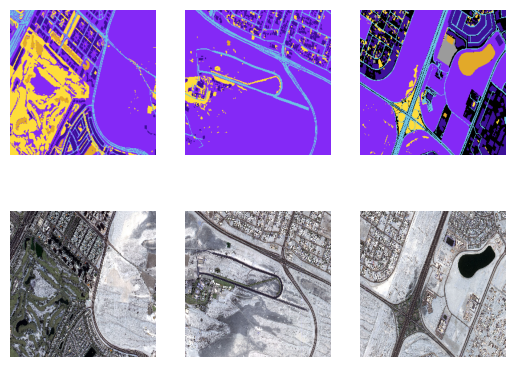

In [ ]:
#Проверка
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
data = [src_images, tar_images] # Формирование датасета

In [ ]:
#Предобработка и формирование обучающей выборки
def preprocess_data(data):
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data) # Предобработка исходного датасета

In [ ]:
image_shape = src_images.shape[1:] # определяем размерность входного слоя на основе загруженного набора данных

# определяем модели
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
from datetime import datetime
n_epochs = 10
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, n_epochs=n_epochs, n_batch=1)
stop1 = datetime.now()
# Время обучения модели
execution_time = stop1-start1
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/n_epochs).total_seconds()/60} минут)")

1/1 [==============================] - 3s 3s/step
Эпоха: 1
Итерация: 1, d1[0.288] d2[2.408] g[39.553]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 2, d1[0.590] d2[2.385] g[47.199]
1/1 [==============================] - 0s 24ms/step
Эпоха: 1
Итерация: 3, d1[1.266] d2[3.029] g[59.016]
1/1 [==============================] - 0s 29ms/step
Эпоха: 1
Итерация: 4, d1[0.976] d2[0.880] g[44.685]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 5, d1[0.481] d2[0.658] g[30.747]
1/1 [==============================] - 0s 27ms/step
Эпоха: 1
Итерация: 6, d1[0.469] d2[0.552] g[40.193]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 7, d1[0.557] d2[0.483] g[61.512]
1/1 [==============================] - 0s 24ms/step
Эпоха: 1
Итерация: 8, d1[0.492] d2[0.440] g[53.035]
1/1 [==============================] - 0s 25ms/step
Эпоха: 1
Итерация: 9, d1[0.511] d2[0.502] g[32.692]
1/1 [==============================] - 0s 22ms/step
Эпоха: 1
Итера

>Saved: plot_000072.png and model_000072.h5
1/1 [==============================] - 0s 31ms/step
Эпоха: 2
Итерация: 73, d1[0.441] d2[0.414] g[40.694]
1/1 [==============================] - 0s 30ms/step
Эпоха: 2
Итерация: 74, d1[0.381] d2[0.478] g[37.158]
1/1 [==============================] - 0s 30ms/step
Эпоха: 2
Итерация: 75, d1[0.445] d2[0.513] g[17.107]
1/1 [==============================] - 0s 33ms/step
Эпоха: 2
Итерация: 76, d1[0.407] d2[0.443] g[47.188]
1/1 [==============================] - 0s 28ms/step
Эпоха: 2
Итерация: 77, d1[0.450] d2[0.371] g[51.439]
1/1 [==============================] - 0s 31ms/step
Эпоха: 2
Итерация: 78, d1[0.449] d2[0.472] g[39.781]
1/1 [==============================] - 0s 37ms/step
Эпоха: 2
Итерация: 79, d1[0.434] d2[0.467] g[33.787]
1/1 [==============================] - 0s 41ms/step
Эпоха: 2
Итерация: 80, d1[0.367] d2[0.463] g[34.581]
1/1 [==============================] - 0s 34ms/step
Эпоха: 2
Итерация: 81, d1[0.470] d2[0.470] g[16.654]
1/1 [======

>Saved: plot_000144.png and model_000144.h5
1/1 [==============================] - 0s 33ms/step
Эпоха: 3
Итерация: 145, d1[0.307] d2[0.503] g[37.049]
1/1 [==============================] - 0s 23ms/step
Эпоха: 3
Итерация: 146, d1[0.404] d2[0.431] g[31.499]
1/1 [==============================] - 0s 21ms/step
Эпоха: 3
Итерация: 147, d1[0.420] d2[0.400] g[19.337]
1/1 [==============================] - 0s 20ms/step
Эпоха: 3
Итерация: 148, d1[0.427] d2[0.447] g[21.181]
1/1 [==============================] - 0s 24ms/step
Эпоха: 3
Итерация: 149, d1[0.413] d2[0.530] g[21.436]
1/1 [==============================] - 0s 23ms/step
Эпоха: 3
Итерация: 150, d1[0.304] d2[0.455] g[34.701]
1/1 [==============================] - 0s 28ms/step
Эпоха: 3
Итерация: 151, d1[0.502] d2[0.377] g[18.512]
1/1 [==============================] - 0s 22ms/step
Эпоха: 3
Итерация: 152, d1[0.377] d2[0.443] g[52.586]
1/1 [==============================] - 0s 20ms/step
Эпоха: 3
Итерация: 153, d1[0.445] d2[0.450] g[17.034]
1/

>Saved: plot_000216.png and model_000216.h5
1/1 [==============================] - 0s 23ms/step
Эпоха: 4
Итерация: 217, d1[0.344] d2[0.417] g[39.163]
1/1 [==============================] - 0s 25ms/step
Эпоха: 4
Итерация: 218, d1[0.396] d2[0.419] g[39.692]
1/1 [==============================] - 0s 25ms/step
Эпоха: 4
Итерация: 219, d1[0.394] d2[0.420] g[42.135]
1/1 [==============================] - 0s 22ms/step
Эпоха: 4
Итерация: 220, d1[0.393] d2[0.413] g[25.927]
1/1 [==============================] - 0s 23ms/step
Эпоха: 4
Итерация: 221, d1[0.393] d2[0.423] g[18.020]
1/1 [==============================] - 0s 24ms/step
Эпоха: 4
Итерация: 222, d1[0.403] d2[0.434] g[29.362]
1/1 [==============================] - 0s 24ms/step
Эпоха: 4
Итерация: 223, d1[0.383] d2[0.398] g[22.550]
1/1 [==============================] - 0s 22ms/step
Эпоха: 4
Итерация: 224, d1[0.402] d2[0.368] g[26.449]
1/1 [==============================] - 0s 22ms/step
Эпоха: 4
Итерация: 225, d1[0.424] d2[0.406] g[25.090]
1/

>Saved: plot_000288.png and model_000288.h5
1/1 [==============================] - 0s 21ms/step
Эпоха: 5
Итерация: 289, d1[0.341] d2[0.397] g[37.099]
1/1 [==============================] - 0s 23ms/step
Эпоха: 5
Итерация: 290, d1[0.421] d2[0.386] g[23.841]
1/1 [==============================] - 0s 22ms/step
Эпоха: 5
Итерация: 291, d1[0.400] d2[0.370] g[32.399]
1/1 [==============================] - 0s 23ms/step
Эпоха: 5
Итерация: 292, d1[0.378] d2[0.395] g[43.564]
1/1 [==============================] - 0s 28ms/step
Эпоха: 5
Итерация: 293, d1[0.437] d2[0.419] g[32.620]
1/1 [==============================] - 0s 30ms/step
Эпоха: 5
Итерация: 294, d1[0.273] d2[0.422] g[24.728]
1/1 [==============================] - 0s 28ms/step
Эпоха: 5
Итерация: 295, d1[0.399] d2[0.380] g[30.779]
1/1 [==============================] - 0s 196ms/step
Эпоха: 5
Итерация: 296, d1[0.326] d2[0.342] g[29.828]
1/1 [==============================] - 0s 113ms/step
Эпоха: 5
Итерация: 297, d1[0.332] d2[0.345] g[31.294]


>Saved: plot_000360.png and model_000360.h5
1/1 [==============================] - 0s 23ms/step
Эпоха: 6
Итерация: 361, d1[0.353] d2[0.417] g[26.961]
1/1 [==============================] - 0s 22ms/step
Эпоха: 6
Итерация: 362, d1[0.340] d2[0.410] g[37.171]
1/1 [==============================] - 0s 105ms/step
Эпоха: 6
Итерация: 363, d1[0.370] d2[0.392] g[24.598]
1/1 [==============================] - 0s 20ms/step
Эпоха: 6
Итерация: 364, d1[0.418] d2[0.370] g[22.240]
1/1 [==============================] - 0s 20ms/step
Эпоха: 6
Итерация: 365, d1[0.368] d2[0.380] g[33.975]
1/1 [==============================] - 0s 22ms/step
Эпоха: 6
Итерация: 366, d1[0.360] d2[0.391] g[25.265]
1/1 [==============================] - 0s 26ms/step
Эпоха: 6
Итерация: 367, d1[0.346] d2[0.418] g[25.489]
1/1 [==============================] - 0s 28ms/step
Эпоха: 6
Итерация: 368, d1[0.347] d2[0.400] g[26.582]
1/1 [==============================] - 0s 20ms/step
Эпоха: 6
Итерация: 369, d1[0.385] d2[0.371] g[29.821]
1

>Saved: plot_000432.png and model_000432.h5
1/1 [==============================] - 0s 46ms/step
Эпоха: 7
Итерация: 433, d1[0.425] d2[0.377] g[17.827]
1/1 [==============================] - 0s 38ms/step
Эпоха: 7
Итерация: 434, d1[0.357] d2[0.364] g[18.354]
1/1 [==============================] - 0s 30ms/step
Эпоха: 7
Итерация: 435, d1[0.320] d2[0.432] g[30.872]
1/1 [==============================] - 0s 28ms/step
Эпоха: 7
Итерация: 436, d1[0.403] d2[0.351] g[17.085]
1/1 [==============================] - 0s 45ms/step
Эпоха: 7
Итерация: 437, d1[0.316] d2[0.429] g[28.972]
1/1 [==============================] - 0s 37ms/step
Эпоха: 7
Итерация: 438, d1[0.398] d2[0.375] g[31.029]
1/1 [==============================] - 0s 34ms/step
Эпоха: 7
Итерация: 439, d1[0.328] d2[0.414] g[28.490]
1/1 [==============================] - 0s 39ms/step
Эпоха: 7
Итерация: 440, d1[0.368] d2[0.379] g[24.006]
1/1 [==============================] - 0s 41ms/step
Эпоха: 7
Итерация: 441, d1[0.384] d2[0.382] g[15.888]
1/

>Saved: plot_000504.png and model_000504.h5
1/1 [==============================] - 0s 24ms/step
Эпоха: 8
Итерация: 505, d1[0.344] d2[0.394] g[47.314]
1/1 [==============================] - 0s 27ms/step
Эпоха: 8
Итерация: 506, d1[0.385] d2[0.341] g[16.598]
1/1 [==============================] - 0s 26ms/step
Эпоха: 8
Итерация: 507, d1[0.344] d2[0.396] g[28.200]
1/1 [==============================] - 0s 22ms/step
Эпоха: 8
Итерация: 508, d1[0.420] d2[0.359] g[16.903]
1/1 [==============================] - 0s 20ms/step
Эпоха: 8
Итерация: 509, d1[0.315] d2[0.423] g[23.943]
1/1 [==============================] - 0s 20ms/step
Эпоха: 8
Итерация: 510, d1[0.365] d2[0.378] g[16.057]
1/1 [==============================] - 0s 24ms/step
Эпоха: 8
Итерация: 511, d1[0.370] d2[0.363] g[15.722]
1/1 [==============================] - 0s 20ms/step
Эпоха: 8
Итерация: 512, d1[0.340] d2[0.399] g[33.399]
1/1 [==============================] - 0s 22ms/step
Эпоха: 8
Итерация: 513, d1[0.366] d2[0.362] g[27.312]
1/

>Saved: plot_000576.png and model_000576.h5
1/1 [==============================] - 0s 23ms/step
Эпоха: 9
Итерация: 577, d1[0.387] d2[0.350] g[27.363]
1/1 [==============================] - 0s 26ms/step
Эпоха: 9
Итерация: 578, d1[0.345] d2[0.361] g[27.031]
1/1 [==============================] - 0s 20ms/step
Эпоха: 9
Итерация: 579, d1[0.351] d2[0.376] g[14.252]
1/1 [==============================] - 0s 20ms/step
Эпоха: 9
Итерация: 580, d1[0.333] d2[0.433] g[22.257]
1/1 [==============================] - 0s 20ms/step
Эпоха: 9
Итерация: 581, d1[0.372] d2[0.392] g[36.533]
1/1 [==============================] - 0s 23ms/step
Эпоха: 9
Итерация: 582, d1[0.341] d2[0.427] g[33.493]
1/1 [==============================] - 0s 23ms/step
Эпоха: 9
Итерация: 583, d1[0.373] d2[0.396] g[33.256]
1/1 [==============================] - 0s 19ms/step
Эпоха: 9
Итерация: 584, d1[0.352] d2[0.406] g[31.342]
1/1 [==============================] - 0s 24ms/step
Эпоха: 9
Итерация: 585, d1[0.370] d2[0.392] g[26.985]
1/

>Saved: plot_000648.png and model_000648.h5
1/1 [==============================] - 0s 32ms/step
Эпоха: 10
Итерация: 649, d1[0.328] d2[0.397] g[27.337]
1/1 [==============================] - 0s 36ms/step
Эпоха: 10
Итерация: 650, d1[0.399] d2[0.354] g[28.322]
1/1 [==============================] - 0s 33ms/step
Эпоха: 10
Итерация: 651, d1[0.360] d2[0.376] g[34.078]
1/1 [==============================] - 0s 46ms/step
Эпоха: 10
Итерация: 652, d1[0.363] d2[0.373] g[21.460]
1/1 [==============================] - 0s 41ms/step
Эпоха: 10
Итерация: 653, d1[0.351] d2[0.361] g[34.011]
1/1 [==============================] - 0s 30ms/step
Эпоха: 10
Итерация: 654, d1[0.360] d2[0.354] g[20.006]
1/1 [==============================] - 0s 34ms/step
Эпоха: 10
Итерация: 655, d1[0.347] d2[0.380] g[41.401]
1/1 [==============================] - 0s 29ms/step
Эпоха: 10
Итерация: 656, d1[0.369] d2[0.365] g[32.050]
1/1 [==============================] - 0s 30ms/step
Эпоха: 10
Итерация: 657, d1[0.372] d2[0.370] g[2

>Saved: plot_000720.png and model_000720.h5
Время обучения модели:  0:03:29.006113 (
Одна эпоха: 0.3483435166666667 минут)


### Демонстрация сгенерированных изображений:

In [ ]:
from numpy.random import randint

In [ ]:

model = load_model('/content/model_000720.h5') # Укажите путь к Вашей обученной модели генератора
#model = g_model

In [ ]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 0s 382ms/step


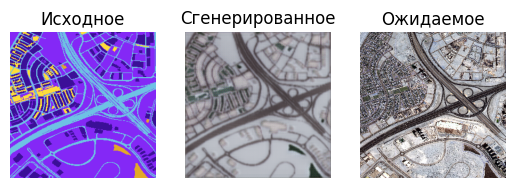

1/1 [==============================] - 0s 21ms/step


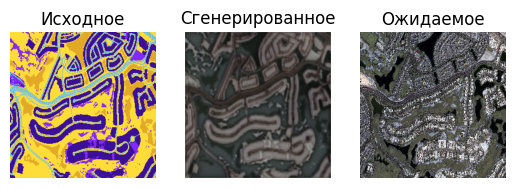

1/1 [==============================] - 0s 20ms/step


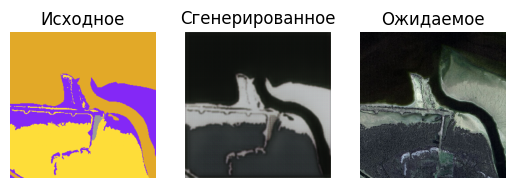

1/1 [==============================] - 0s 20ms/step


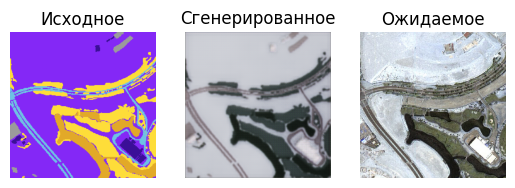

1/1 [==============================] - 0s 31ms/step


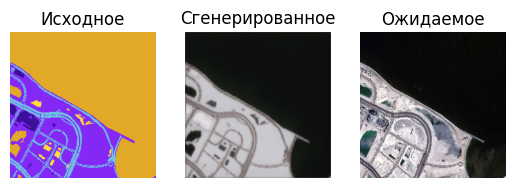

1/1 [==============================] - 0s 39ms/step


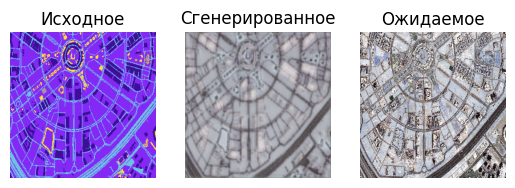

1/1 [==============================] - 0s 94ms/step


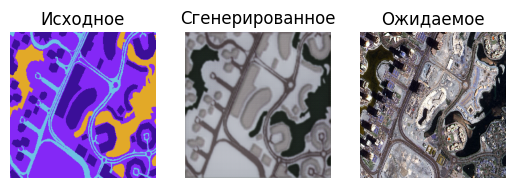

1/1 [==============================] - 0s 25ms/step


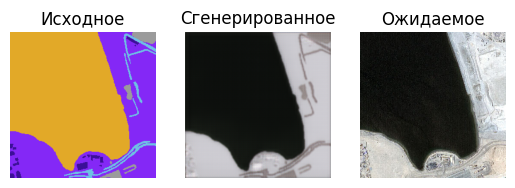

1/1 [==============================] - 0s 23ms/step


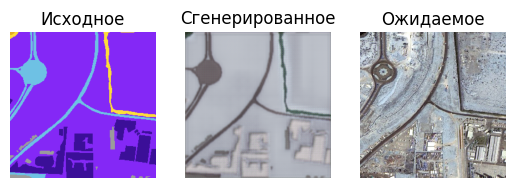

1/1 [==============================] - 0s 23ms/step


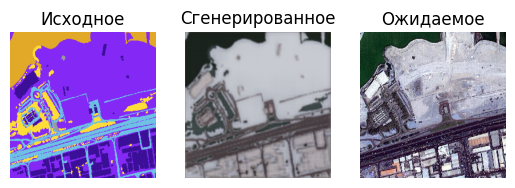

In [ ]:

[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту

# **Задание №4.** Обучите генератор воспроизводить изображения из выбранного Вами датасета (pix2pix).

### Датасет может быть сформирован Вами (например, черно-белые и цветные изображения) или найден в глобальной сети Интернет.

#### Например [тут](https://www.kaggle.com/search?q=pix2pix+in%3Adatasets+datasetFileTypes%3Ajpg+datasetFileTypes%3Apng) или [тут](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
from urllib.request import urlopen
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from imutils import paths
import os
import tensorflow as tf
import random

In [ ]:
def define_discriminator(image_shape):

	# инициализация веса
	init = RandomNormal(stddev=0.02) # Как описано в оригинальной статье

	# Входной слой для исходного изображения
	in_src_image = Input(shape=image_shape)  # Изображение, которое мы хотим преобразовать в другое изображение
       # Входной слой для целевого изображения
	in_target_image = Input(shape=image_shape)  # Изображение, которое мы хотим получить после обучения.

       # конкатенируем изображения по каналам
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2. Этот блок кода добавлен самостоятельно, его нет в оригинальной статье. Закомментируйте его, если хотите.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# последний выходной слой: 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# формирование патча
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# определяем модель
	model = Model([in_src_image, in_target_image], patch_out)

   #Модель обучается с размером партии в одно изображение, оптимизатором Adam с небольшой скоростью обучения и значением beta = 0.5.
    # Устанавливаем весовой коэффициент для дискриминатора в 50% (0.5) .

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


In [ ]:
#Конструктор Генератора (U-net)
#Определим блок энкодера:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
       # добавим слой понижающей дискретизации
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
      # добавим опционально нормализацию батчей
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
#Определим блок декодера:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
	# добавим слой повышающей дискретизации
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# добавим нормализацию батчей
	g = BatchNormalization()(g, training=True)
	# опционально добавим дропаут
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# объединяем с пропуском соединения (skip connection)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
#Определим модель автономного генератора - U-net
def define_generator(image_shape=(256,256,3)):
	# инициализация веса
	init = RandomNormal(stddev=0.02)
	# входной слой для изображения
	in_image = Input(shape=image_shape)
	# Архитектура энкодера: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Архитектура декодера: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)  #Генерируется изображение в диапазоне от -1 до 1.
	# Определяем модель
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
# определяем комбинированную модель генератора и дискриминатора, для обновления генератора
def define_gan(g_model, d_model, image_shape):
	# делаем веса в дискриминаторе не обучаемыми
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Слои дескриминатора установлены на необучаемые в комбинированной GAN, но
                                    # отдельный дескриминатор будет обучаемым.

	# определим входной слой для исходного изображения
	in_src = Input(shape=image_shape)
	# подаём изображение на вход генератора
	gen_out = g_model(in_src)
	# подаём входное изображения и сформированного изображения в качестве входных данных в дискриминатор
	dis_out = d_model([in_src, gen_out])
	# входное изображение в качестве входа, сгенерированное изображение и значение выходного слоя дискриминатора в качестве выходов
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)

  #Общая потеря - это взвешенная сумма потерь от “состязательности” (Бинарная кросс-энтропия) и потери от MAE (L1).
  #Авторы предложили взвесить соотношение BCE и MAE как 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
#Определим модель автономного генератора - U-net
def generate_real_samples(dataset, n_samples, patch_shape):
	# распаковка набора данных
	trainA, trainB = dataset
	# выбор случайных экземпляры
	ix = randint(0, trainA.shape[0], n_samples)
	# извлечение выбранных изображений
	X1, X2 = trainA[ix], trainB[ix]
	# генерация "реальных" меток классов (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
#Генератор набора "поддельных" изображений
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# генерация "поддельных" меток классов (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
#Функция для проверки генератора и визуализации его работы, а также сохранение модели.
def summarize_performance(step, g_model, dataset, n_samples=3):
	# формирование выборки входных изображений
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# генерация партии поддельных изображений
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Нормализация
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(os.path.join("/content/drive/MyDrive/content/mod", filename2))
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
#Функция для обучения моделей
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# определение размерности выходного значения дискриминатора
	n_patch = d_model.output_shape[1]
	# распаковка датасета
	trainA, trainB = dataset
	# вычисление количества партий на одну эпоху обучения
	bat_per_epo = int(len(trainA) / n_batch)
	# вычисление количества тренировочных итераций
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
 		# формирование партии обучающей выборки (реальных образцов)
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# генерация партии поддельных образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# обучение дискриминатора на реальных образцах
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# обучение дискриминатора на «поддельных» образцах
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# обучение генератора
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# индикация процесса обучения
		print(f'Эпоха: {((i+1) // bat_per_epo) + 1}')
		print('Итерация: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0: # Сохраняем модель генератора и набор изображений каждую (1) эпоху.
			summarize_performance(i, g_model, dataset)

In [ ]:
#Устанавливаем необходимые зависимости
import os
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
#Загружаем исходные данные
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_images(path, size=(256,256)):
  src_list, tar_list = list(), list()
  files = [f for f in listdir(os.path.join(path, "images")) if isfile(join(os.path.join(path, "images"), f))]
  for i in range(10):
    pixels = load_img(os.path.join(path, "images", files[i]), target_size=size)
    src_list.append(img_to_array(pixels))
    pixels = load_img(os.path.join(path, "masks", files[i]), target_size=size)
    tar_list.append(img_to_array(pixels))
  return [asarray(src_list), asarray(tar_list)]

In [ ]:
import os
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import load_img, img_to_array
from numpy import asarray

def load_images(path, size=(256, 256)):
    src_list, tar_list = list(), list()
    image_dir = os.path.join(path, "images")
    mask_dir = os.path.join(path, "masks")

    # Получение списка файлов в директории `images`
    files = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]

    for i in range(min(10, len(files))):  # Обработка только доступных файлов, если их меньше 10
        # Загрузка изображения
        image_path = os.path.join(image_dir, files[i])
        pixels = load_img(image_path, target_size=size)
        src_list.append(img_to_array(pixels))

        # Загрузка маски
        mask_path = os.path.join(mask_dir, files[i])
        pixels = load_img(mask_path, target_size=size)
        tar_list.append(img_to_array(pixels))

    return [asarray(src_list), asarray(tar_list)]

# Указание пути к датасету
path = '/content/drive/MyDrive/content/city'

# Загрузка изображений и масок
try:
    src_images, tar_images = load_images(path)
    print('Загружено:', src_images.shape, tar_images.shape)
except Exception as e:
    print(f'Ошибка: {e}')

Загружено: (10, 256, 256, 3) (10, 256, 256, 3)


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
path = '/content/drive/MyDrive/content/city' # путь к датасету
[src_images, tar_images] = load_images(path) # загрузка датасета

print('Загружено: ', src_images.shape, tar_images.shape)

Загружено:  (10, 256, 256, 3) (10, 256, 256, 3)


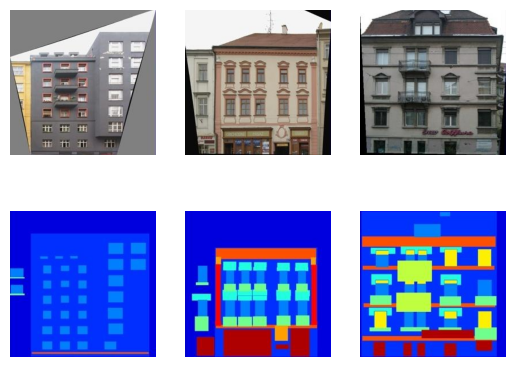

In [ ]:
#Проверка
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
data = [src_images, tar_images] # Формирование датасета

In [ ]:
#Предобработка и формирование обучающей выборки
def preprocess_data(data):
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data) # Предобработка исходного датасета

In [ ]:
image_shape = src_images.shape[1:] # определяем размерность входного слоя на основе загруженного набора данных

# определяем модели
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
from datetime import datetime
n_epochs = 10
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, n_epochs=n_epochs, n_batch=1)
stop1 = datetime.now()
# Время обучения модели
execution_time = stop1-start1
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/n_epochs).total_seconds()/60} минут)")

1/1 [==============================] - 0s 473ms/step
Эпоха: 1
Итерация: 1, d1[0.488] d2[0.167] g[38.378]
1/1 [==============================] - 1s 565ms/step
Эпоха: 1
Итерация: 2, d1[0.242] d2[0.188] g[36.532]
1/1 [==============================] - 1s 666ms/step
Эпоха: 1
Итерация: 3, d1[0.307] d2[0.688] g[19.597]
1/1 [==============================] - 0s 485ms/step
Эпоха: 1
Итерация: 4, d1[0.386] d2[0.324] g[55.910]
1/1 [==============================] - 0s 450ms/step
Эпоха: 1
Итерация: 5, d1[0.296] d2[0.288] g[37.712]
1/1 [==============================] - 0s 470ms/step
Эпоха: 1
Итерация: 6, d1[0.268] d2[0.791] g[48.619]
1/1 [==============================] - 1s 679ms/step
Эпоха: 1
Итерация: 7, d1[0.467] d2[0.429] g[46.858]
1/1 [==============================] - 0s 463ms/step
Эпоха: 1
Итерация: 8, d1[0.398] d2[0.343] g[46.319]
1/1 [==============================] - 0s 453ms/step
Эпоха: 1
Итерация: 9, d1[0.579] d2[0.678] g[17.702]
1/1 [==============================] - 0s 464ms/step
Эп

>Saved: plot_000010.png and model_000010.h5
1/1 [==============================] - 0s 480ms/step
Эпоха: 2
Итерация: 11, d1[0.453] d2[0.313] g[35.707]
1/1 [==============================] - 0s 470ms/step
Эпоха: 2
Итерация: 12, d1[0.255] d2[0.345] g[47.376]
1/1 [==============================] - 1s 698ms/step
Эпоха: 2
Итерация: 13, d1[0.255] d2[0.083] g[37.836]
1/1 [==============================] - 0s 474ms/step
Эпоха: 2
Итерация: 14, d1[0.264] d2[0.109] g[34.765]
1/1 [==============================] - 0s 468ms/step
Эпоха: 2
Итерация: 15, d1[0.183] d2[0.184] g[61.882]
1/1 [==============================] - 1s 565ms/step
Эпоха: 2
Итерация: 16, d1[0.072] d2[0.089] g[36.260]
1/1 [==============================] - 1s 668ms/step
Эпоха: 2
Итерация: 17, d1[0.185] d2[0.172] g[37.335]
1/1 [==============================] - 0s 465ms/step
Эпоха: 2
Итерация: 18, d1[0.335] d2[0.235] g[22.351]
1/1 [==============================] - 0s 477ms/step
Эпоха: 2
Итерация: 19, d1[0.071] d2[0.387] g[47.986]
1/

>Saved: plot_000020.png and model_000020.h5
1/1 [==============================] - 0s 464ms/step
Эпоха: 3
Итерация: 21, d1[0.100] d2[0.080] g[34.495]
1/1 [==============================] - 0s 460ms/step
Эпоха: 3
Итерация: 22, d1[0.055] d2[0.071] g[34.619]
1/1 [==============================] - 1s 968ms/step
Эпоха: 3
Итерация: 23, d1[0.055] d2[0.116] g[45.684]
1/1 [==============================] - 0s 490ms/step
Эпоха: 3
Итерация: 24, d1[0.642] d2[0.963] g[24.735]
1/1 [==============================] - 0s 469ms/step
Эпоха: 3
Итерация: 25, d1[0.307] d2[0.218] g[23.737]
1/1 [==============================] - 1s 689ms/step
Эпоха: 3
Итерация: 26, d1[0.382] d2[0.128] g[37.759]
1/1 [==============================] - 0s 452ms/step
Эпоха: 3
Итерация: 27, d1[0.517] d2[0.061] g[56.918]
1/1 [==============================] - 0s 465ms/step
Эпоха: 3
Итерация: 28, d1[0.161] d2[0.035] g[20.046]
1/1 [==============================] - 0s 481ms/step
Эпоха: 3
Итерация: 29, d1[0.077] d2[0.032] g[16.940]
1/

>Saved: plot_000030.png and model_000030.h5
1/1 [==============================] - 1s 504ms/step
Эпоха: 4
Итерация: 31, d1[0.033] d2[0.028] g[56.219]
1/1 [==============================] - 1s 526ms/step
Эпоха: 4
Итерация: 32, d1[0.019] d2[0.045] g[46.350]
1/1 [==============================] - 1s 530ms/step
Эпоха: 4
Итерация: 33, d1[0.023] d2[0.022] g[34.335]
1/1 [==============================] - 0s 464ms/step
Эпоха: 4
Итерация: 34, d1[0.014] d2[0.017] g[59.763]
1/1 [==============================] - 0s 454ms/step
Эпоха: 4
Итерация: 35, d1[0.026] d2[0.015] g[37.773]
1/1 [==============================] - 1s 673ms/step
Эпоха: 4
Итерация: 36, d1[0.017] d2[0.028] g[36.234]
1/1 [==============================] - 0s 461ms/step
Эпоха: 4
Итерация: 37, d1[0.176] d2[0.534] g[23.516]
1/1 [==============================] - 0s 457ms/step
Эпоха: 4
Итерация: 38, d1[0.062] d2[0.024] g[62.352]
1/1 [==============================] - 0s 452ms/step
Эпоха: 4
Итерация: 39, d1[0.088] d2[0.014] g[60.871]
1/

>Saved: plot_000040.png and model_000040.h5
1/1 [==============================] - 0s 462ms/step
Эпоха: 5
Итерация: 41, d1[0.030] d2[0.076] g[17.910]
1/1 [==============================] - 0s 448ms/step
Эпоха: 5
Итерация: 42, d1[0.043] d2[0.019] g[25.774]
1/1 [==============================] - 1s 708ms/step
Эпоха: 5
Итерация: 43, d1[0.009] d2[0.011] g[62.185]
1/1 [==============================] - 0s 476ms/step
Эпоха: 5
Итерация: 44, d1[0.010] d2[0.017] g[60.723]
1/1 [==============================] - 0s 465ms/step
Эпоха: 5
Итерация: 45, d1[0.016] d2[0.013] g[37.474]
1/1 [==============================] - 1s 669ms/step
Эпоха: 5
Итерация: 46, d1[0.007] d2[0.036] g[58.031]
1/1 [==============================] - 0s 472ms/step
Эпоха: 5
Итерация: 47, d1[0.013] d2[0.013] g[48.516]
1/1 [==============================] - 0s 453ms/step
Эпоха: 5
Итерация: 48, d1[0.012] d2[0.012] g[58.303]
1/1 [==============================] - 0s 461ms/step
Эпоха: 5
Итерация: 49, d1[0.008] d2[0.104] g[56.876]
1/

>Saved: plot_000050.png and model_000050.h5
1/1 [==============================] - 0s 478ms/step
Эпоха: 6
Итерация: 51, d1[0.014] d2[0.064] g[46.700]
1/1 [==============================] - 1s 583ms/step
Эпоха: 6
Итерация: 52, d1[0.025] d2[0.011] g[35.651]
1/1 [==============================] - 1s 567ms/step
Эпоха: 6
Итерация: 53, d1[0.013] d2[0.008] g[34.141]
1/1 [==============================] - 0s 465ms/step
Эпоха: 6
Итерация: 54, d1[0.055] d2[0.010] g[25.763]
1/1 [==============================] - 0s 459ms/step
Эпоха: 6
Итерация: 55, d1[0.014] d2[0.013] g[20.775]
1/1 [==============================] - 1s 690ms/step
Эпоха: 6
Итерация: 56, d1[0.008] d2[0.010] g[45.496]
1/1 [==============================] - 0s 470ms/step
Эпоха: 6
Итерация: 57, d1[0.006] d2[0.010] g[44.141]
1/1 [==============================] - 0s 470ms/step
Эпоха: 6
Итерация: 58, d1[0.007] d2[0.010] g[55.034]
1/1 [==============================] - 1s 682ms/step
Эпоха: 6
Итерация: 59, d1[0.005] d2[0.011] g[57.328]
1/

>Saved: plot_000060.png and model_000060.h5
1/1 [==============================] - 0s 496ms/step
Эпоха: 7
Итерация: 61, d1[0.005] d2[0.008] g[49.805]
1/1 [==============================] - 1s 646ms/step
Эпоха: 7
Итерация: 62, d1[0.023] d2[0.010] g[26.766]
1/1 [==============================] - 0s 455ms/step
Эпоха: 7
Итерация: 63, d1[0.006] d2[0.009] g[51.824]
1/1 [==============================] - 0s 479ms/step
Эпоха: 7
Итерация: 64, d1[0.005] d2[0.008] g[45.157]
1/1 [==============================] - 1s 659ms/step
Эпоха: 7
Итерация: 65, d1[0.005] d2[0.009] g[43.002]
1/1 [==============================] - 0s 447ms/step
Эпоха: 7
Итерация: 66, d1[0.006] d2[0.202] g[59.109]
1/1 [==============================] - 0s 465ms/step
Эпоха: 7
Итерация: 67, d1[0.022] d2[0.012] g[54.405]
1/1 [==============================] - 0s 466ms/step
Эпоха: 7
Итерация: 68, d1[1.051] d2[2.256] g[33.340]
1/1 [==============================] - 1s 675ms/step
Эпоха: 7
Итерация: 69, d1[0.015] d2[0.643] g[54.545]
1/

>Saved: plot_000070.png and model_000070.h5
1/1 [==============================] - 0s 466ms/step
Эпоха: 8
Итерация: 71, d1[0.417] d2[0.225] g[54.975]
1/1 [==============================] - 1s 685ms/step
Эпоха: 8
Итерация: 72, d1[0.172] d2[0.183] g[37.297]
1/1 [==============================] - 1s 546ms/step
Эпоха: 8
Итерация: 73, d1[0.102] d2[0.227] g[34.777]
1/1 [==============================] - 0s 466ms/step
Эпоха: 8
Итерация: 74, d1[0.295] d2[0.066] g[49.345]
1/1 [==============================] - 1s 663ms/step
Эпоха: 8
Итерация: 75, d1[0.812] d2[1.775] g[31.829]
1/1 [==============================] - 0s 474ms/step
Эпоха: 8
Итерация: 76, d1[0.353] d2[0.918] g[21.219]
1/1 [==============================] - 0s 473ms/step
Эпоха: 8
Итерация: 77, d1[0.506] d2[0.146] g[51.177]
1/1 [==============================] - 0s 455ms/step
Эпоха: 8
Итерация: 78, d1[0.543] d2[0.173] g[50.978]
1/1 [==============================] - 1s 668ms/step
Эпоха: 8
Итерация: 79, d1[0.139] d2[0.441] g[42.251]
1/

>Saved: plot_000080.png and model_000080.h5
1/1 [==============================] - 0s 468ms/step
Эпоха: 9
Итерация: 81, d1[0.283] d2[0.183] g[29.257]
1/1 [==============================] - 1s 686ms/step
Эпоха: 9
Итерация: 82, d1[0.312] d2[0.331] g[32.106]
1/1 [==============================] - 1s 646ms/step
Эпоха: 9
Итерация: 83, d1[0.043] d2[0.142] g[34.397]
1/1 [==============================] - 0s 493ms/step
Эпоха: 9
Итерация: 84, d1[0.092] d2[0.041] g[31.417]
1/1 [==============================] - 1s 510ms/step
Эпоха: 9
Итерация: 85, d1[0.226] d2[1.166] g[20.995]
1/1 [==============================] - 0s 463ms/step
Эпоха: 9
Итерация: 86, d1[0.597] d2[0.568] g[16.698]
1/1 [==============================] - 0s 457ms/step
Эпоха: 9
Итерация: 87, d1[0.395] d2[0.382] g[47.822]
1/1 [==============================] - 0s 453ms/step
Эпоха: 9
Итерация: 88, d1[1.193] d2[0.785] g[48.877]
1/1 [==============================] - 1s 677ms/step
Эпоха: 9
Итерация: 89, d1[0.598] d2[0.740] g[15.091]
1/

>Saved: plot_000090.png and model_000090.h5
1/1 [==============================] - 0s 452ms/step
Эпоха: 10
Итерация: 91, d1[0.378] d2[0.428] g[42.065]
1/1 [==============================] - 1s 685ms/step
Эпоха: 10
Итерация: 92, d1[0.371] d2[0.358] g[49.665]
1/1 [==============================] - 0s 472ms/step
Эпоха: 10
Итерация: 93, d1[0.629] d2[0.804] g[28.590]
1/1 [==============================] - 0s 456ms/step
Эпоха: 10
Итерация: 94, d1[0.432] d2[0.582] g[25.552]
1/1 [==============================] - 0s 448ms/step
Эпоха: 10
Итерация: 95, d1[0.351] d2[0.429] g[35.072]
1/1 [==============================] - 1s 680ms/step
Эпоха: 10
Итерация: 96, d1[0.327] d2[0.222] g[30.514]
1/1 [==============================] - 0s 454ms/step
Эпоха: 10
Итерация: 97, d1[0.365] d2[0.476] g[40.613]
1/1 [==============================] - 0s 464ms/step
Эпоха: 10
Итерация: 98, d1[1.714] d2[0.303] g[41.582]
1/1 [==============================] - 1s 558ms/step
Эпоха: 10
Итерация: 99, d1[0.399] d2[0.810] g[2

>Saved: plot_000100.png and model_000100.h5
Время обучения модели:  0:07:39.737435 (
Одна эпоха: 0.7662290666666667 минут)


In [ ]:
from keras.models import load_model
from numpy.random import randint

In [ ]:

model = load_model('/content/drive/MyDrive/content/mod/model_000100.h5') # Укажите путь к Вашей обученной модели генератора
#model = g_model

In [ ]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 1s 1s/step


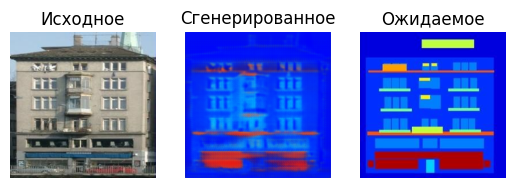

1/1 [==============================] - 1s 1s/step


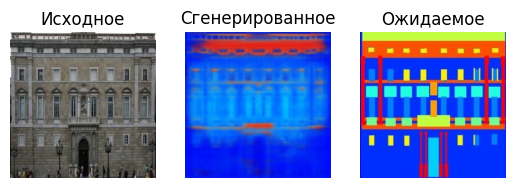

1/1 [==============================] - 1s 664ms/step


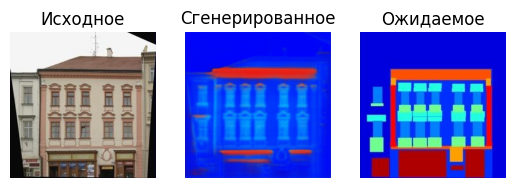

1/1 [==============================] - 1s 657ms/step


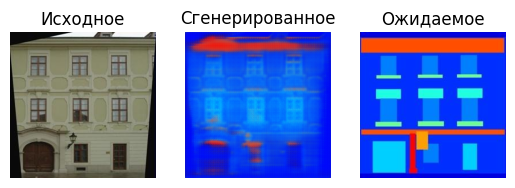

1/1 [==============================] - 1s 638ms/step


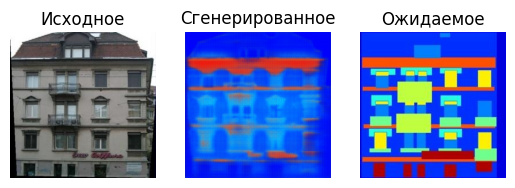

1/1 [==============================] - 0s 457ms/step


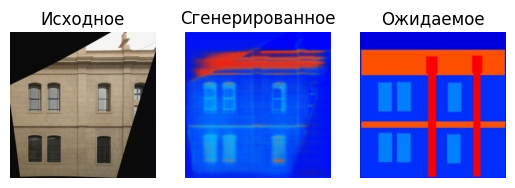

1/1 [==============================] - 0s 452ms/step


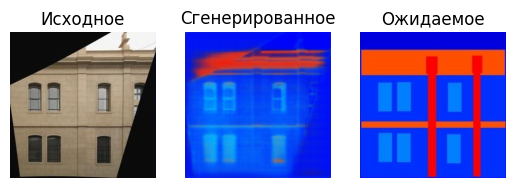

1/1 [==============================] - 0s 459ms/step


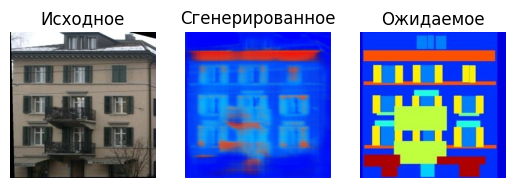

1/1 [==============================] - 0s 473ms/step


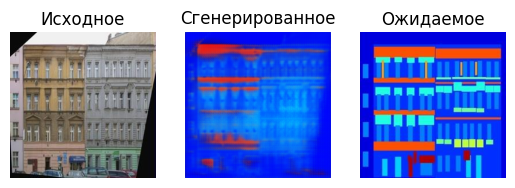

1/1 [==============================] - 0s 457ms/step


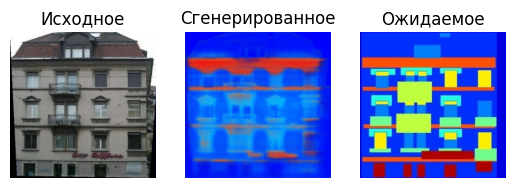

In [ ]:

[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту